In [113]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [114]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Hi_Scan.csv')


In [115]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingHiScan.csv')

In [116]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,LCS,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2
0,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,13178.0,0.219727,0.946579,711,854,56.207333,1,0.118133,0.440499,...,0.544710,0.789882,0.652122,0.295580,0.072267,0.382839,0.066852,0.232336,0.036582,0.014911
1,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,9747.0,0.274930,0.936989,824,625,131.101257,1,0.138338,0.448819,...,0.490053,0.800080,0.694828,0.281776,0.080720,0.364816,0.059893,0.213834,0.040929,0.013465
2,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,13996.0,0.288037,0.931608,641,810,77.537815,1,0.129546,0.417269,...,0.613749,0.727275,0.624069,0.281670,0.076565,0.353852,0.070547,0.194776,0.039335,0.014506
3,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,14398.0,0.177999,0.965868,951,951,35.501984,1,0.137562,0.439181,...,0.535034,0.787512,0.663406,0.275971,0.064886,0.374370,0.065110,0.219560,0.047868,0.013591
4,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,29435.0,0.166856,0.973550,1312,802,64.374107,1,0.140779,0.434023,...,0.518533,0.764734,0.649534,0.270623,0.086478,0.418587,0.063477,0.224307,0.041850,0.013170


In [117]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = "train"    
train_indices = train[train.Set=="train"].index

In [118]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [119]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Filename 1999
Class 2
Set 1


In [120]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,999,13178.0,0.219727,0.946579,711,854,56.207333,1,0.118133,0.440499,...,0.789882,0.652122,0.295580,0.072267,0.382839,0.066852,0.232336,0.036582,0.014911,0
1,1000,9747.0,0.274930,0.936989,824,625,131.101257,1,0.138338,0.448819,...,0.800080,0.694828,0.281776,0.080720,0.364816,0.059893,0.213834,0.040929,0.013465,0
2,1001,13996.0,0.288037,0.931608,641,810,77.537815,1,0.129546,0.417269,...,0.727275,0.624069,0.281670,0.076565,0.353852,0.070547,0.194776,0.039335,0.014506,0
3,1002,14398.0,0.177999,0.965868,951,951,35.501984,1,0.137562,0.439181,...,0.787512,0.663406,0.275971,0.064886,0.374370,0.065110,0.219560,0.047868,0.013591,0
4,1003,29435.0,0.166856,0.973550,1312,802,64.374107,1,0.140779,0.434023,...,0.764734,0.649534,0.270623,0.086478,0.418587,0.063477,0.224307,0.041850,0.013170,0


In [121]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Filename 2500
Class 2
Set 1


In [122]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [123]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [124]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


In [125]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [126]:
X_train[0]

array([9.99000000e+02, 1.31780000e+04, 2.19727291e-01, 9.46579134e-01,
       7.11000000e+02, 8.54000000e+02, 5.62073330e+01, 1.18132624e-01,
       4.40498972e-01, 2.78448906e-01, 1.36566574e+04, 2.75377057e-01,
       7.76108286e-01, 3.33161397e-01, 9.29752066e-01, 7.94043908e+01,
       2.11272088e+02, 8.02096599e-01, 5.44710371e-01, 7.89881723e-01,
       6.52122256e-01, 2.95579635e-01, 7.22670940e-02, 3.82839485e-01,
       6.68521940e-02, 2.32336088e-01, 3.65819200e-02, 1.49114170e-02])

In [127]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [128]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.76555 | train_auc: 0.59727 | valid_auc: 0.66774 |  0:00:00s
epoch 1  | loss: 0.54447 | train_auc: 0.47256 | valid_auc: 0.62219 |  0:00:00s
epoch 2  | loss: 0.46743 | train_auc: 0.35649 | valid_auc: 0.5709  |  0:00:00s
epoch 3  | loss: 0.39873 | train_auc: 0.34318 | valid_auc: 0.47976 |  0:00:00s
epoch 4  | loss: 0.35538 | train_auc: 0.42956 | valid_auc: 0.33942 |  0:00:00s
epoch 5  | loss: 0.33166 | train_auc: 0.5326  | valid_auc: 0.66912 |  0:00:00s
epoch 6  | loss: 0.27689 | train_auc: 0.49778 | valid_auc: 0.59917 |  0:00:01s
epoch 7  | loss: 0.25762 | train_auc: 0.51931 | valid_auc: 0.51922 |  0:00:01s
epoch 8  | loss: 0.22137 | train_auc: 0.55958 | valid_auc: 0.59511 |  0:00:01s
epoch 9  | loss: 0.21698 | train_auc: 0.62191 | valid_auc: 0.58635 |  0:00:02s
epoch 10 | loss: 0.19259 | train_auc: 0.68553 | valid_auc: 0.70502 |  0:00:02s
epoch 11 | loss: 0.19474 | train_auc: 0.72336 | valid_auc: 0.83337 |  0:00:02s
epoch 12 | loss: 0.19377 | train_auc: 0.74055 | vali

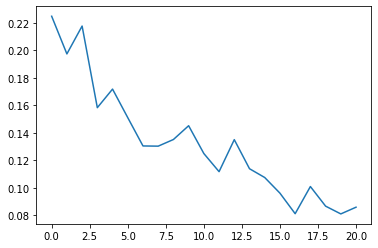

In [129]:
plt.plot(clf.history['loss'])

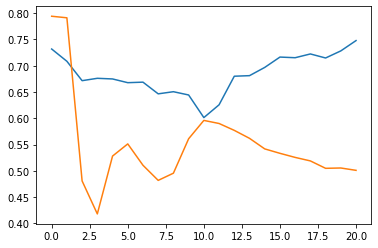

In [130]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

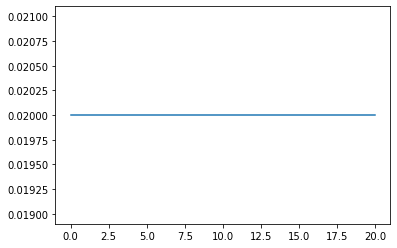

In [131]:
plt.plot(clf.history['lr'])

In [98]:
target = 'Class'

In [132]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', length=2500)

In [133]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1500,8266.5,0.383349,0.839418,288,1994,99.187955,classOne,0.153912,0.410613,...,0.797049,0.669485,0.402786,0.113667,0.336519,0.065256,0.236921,0.237541,0.019568,0
1,1501,47155.5,0.372415,0.896262,1652,1451,417.176479,classOne,0.187894,0.374278,...,0.850782,0.619929,0.338296,0.095768,0.323855,0.046135,0.228830,0.249255,0.017525,0
2,1502,21913.5,0.152613,0.963557,1586,2166,479.199968,classOne,0.146315,0.390184,...,0.812172,0.601877,0.426878,0.092892,0.316652,0.067649,0.225560,0.299585,0.020124,0
3,1503,44836.5,0.240996,0.941365,1335,1452,454.597828,classOne,0.160246,0.403237,...,0.808584,0.645700,0.320552,0.100989,0.339780,0.055888,0.226648,0.132427,0.016810,0
4,1504,22673.0,0.203558,0.937257,1404,2188,211.361639,classOne,0.145250,0.364457,...,0.822868,0.589776,0.349245,0.111315,0.285965,0.055115,0.232615,0.286615,0.017075,0


Filename 2391
Class 2
Set 1


In [ ]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1430,1247.5,0.180888,0.970647,662,561,78.533838,1,0.088992,0.159958,...,0.773165,0.428583,1.196166,0.074062,0.078522,0.128689,0.069774,0.279889,0.044990,0
1,1431,9068.5,0.171969,0.972397,751,579,81.857239,1,0.126087,0.183584,...,0.589470,0.420638,1.365218,0.098366,0.093950,0.189146,0.091914,0.137530,0.048323,0
2,1432,2391.0,0.185029,0.969472,869,548,80.215418,1,0.100562,0.209148,...,0.581448,0.424211,1.336425,0.069207,0.206090,0.168276,0.133136,0.237812,0.049219,0
3,1433,2844.0,0.163861,0.975126,1252,619,26.679455,1,0.101059,0.309550,...,0.696221,0.425945,1.067160,0.080500,0.302677,0.165879,0.222617,0.340390,0.043068,0
4,1434,2188.5,0.176749,0.970335,842,510,78.065596,1,0.121961,0.209846,...,0.594424,0.461999,1.323560,0.085743,0.139873,0.207683,0.142900,0.387912,0.045935,0


In [ ]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1430,1247.5,0.180888,0.970647,662,561,78.533838,classOne,0.088992,0.159958,...,0.773165,0.428583,1.196166,0.074062,0.078522,0.128689,0.069774,0.279889,0.044990,0
1,1431,9068.5,0.171969,0.972397,751,579,81.857239,classOne,0.126087,0.183584,...,0.589470,0.420638,1.365218,0.098366,0.093950,0.189146,0.091914,0.137530,0.048323,0
2,1432,2391.0,0.185029,0.969472,869,548,80.215418,classOne,0.100562,0.209148,...,0.581448,0.424211,1.336425,0.069207,0.206090,0.168276,0.133136,0.237812,0.049219,0
3,1433,2844.0,0.163861,0.975126,1252,619,26.679455,classOne,0.101059,0.309550,...,0.696221,0.425945,1.067160,0.080500,0.302677,0.165879,0.222617,0.340390,0.043068,0
4,1434,2188.5,0.176749,0.970335,842,510,78.065596,classOne,0.121961,0.209846,...,0.594424,0.461999,1.323560,0.085743,0.139873,0.207683,0.142900,0.387912,0.045935,0


In [134]:
features

['Filename',
 'White Circle Patch',
 'Contrast',
 'Black Patch',
 'Biffercation',
 'Termination',
 'CID',
 'OCL_STD',
 'LCS_STD',
 'OFL_STD',
 'RPS',
 'FDA_STD',
 'RVU',
 'GABOR_STD',
 'GABORSHEN',
 'SIGMA',
 'MEAN',
 'OCL',
 'LCS',
 'OFL',
 'FDA',
 'GABOR',
 'OCL_STD2',
 'LCS_STD2',
 'OFL_STD2',
 'FDA_STD2',
 'RVU_STD2',
 'GABOR_STD2']

In [135]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_test)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.794175703957382
FINAL TEST SCORE : 0.7994160000000001


In [136]:
clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classZero',
       'classZero'], dtype='<U9')

In [137]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [138]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [139]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.7994160000000001


In [140]:
assert(test_auc == loaded_test_auc)

In [141]:
loaded_clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classZero',
       'classZero'], dtype='<U9')

In [142]:
clf.feature_importances_

array([7.09920249e-03, 1.47145960e-02, 1.43927038e-01, 2.46193650e-03,
       5.53181425e-02, 1.60794391e-02, 2.08637861e-01, 4.74908869e-03,
       4.19176532e-03, 2.03365997e-04, 3.46683897e-01, 3.67920590e-04,
       7.16235961e-03, 1.11630969e-02, 1.04743489e-03, 2.78257129e-02,
       5.65769182e-04, 4.16531021e-03, 2.33800127e-04, 9.08331662e-05,
       3.75665005e-03, 7.26838616e-02, 4.64383522e-03, 8.26742297e-03,
       1.19949466e-04, 4.63023150e-02, 6.31797394e-03, 1.21942101e-03])

In [143]:
explain_matrix, masks = clf.explain(X_test)

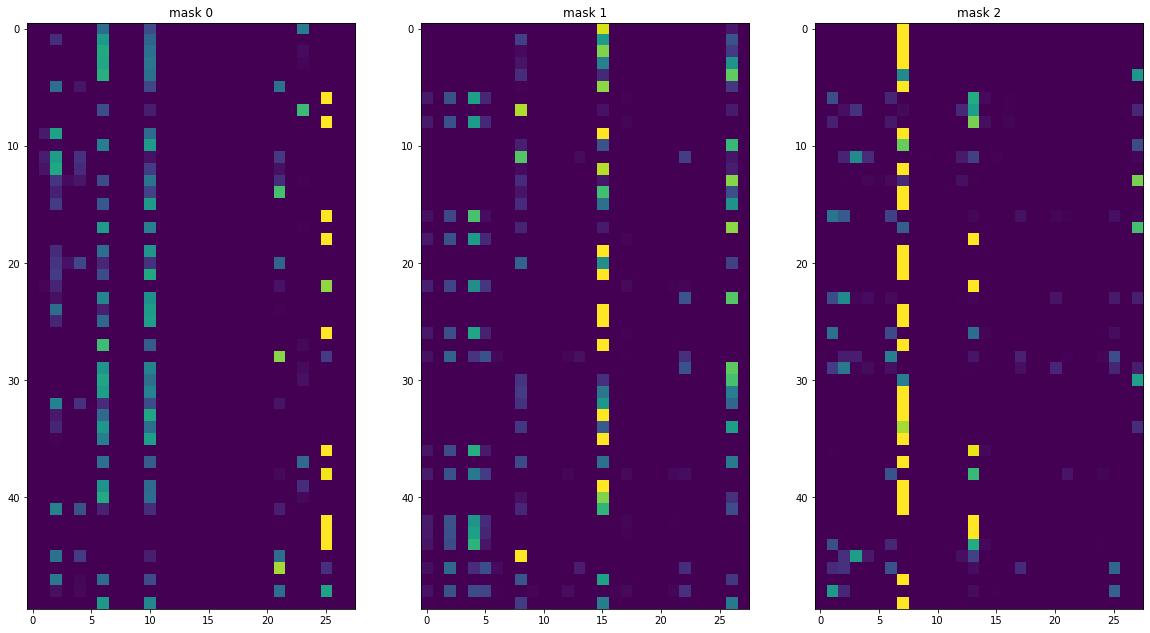

In [144]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")